# **Time Series Forecasting**

Analisis deret waktu (time series) merupakan pendekatan yang digunakan untuk memahami pola data yang tersusun berdasarkan urutan waktu. Dengan mempelajari pola historis, kita dapat mengidentifikasi tren, musiman, maupun fluktuasi acak yang ada di dalam data.

Data yang digunakan dalam analisis ini berasal dari satelit Sentinel‑5P, yaitu misi penginderaan jauh milik European Space Agency (ESA) yang dirancang khusus untuk memantau kualitas udara global. Akses data dilakukan melalui platform openEO, sebuah antarmuka pemrosesan data penginderaan jauh berbasis cloud yang memungkinkan pengguna mengambil dan mengolah data satelit tanpa harus mengunduh seluruh arsip mentah.
Wilayah kajian difokuskan pada kota Surabaya di Jawa Timur, Indonesia. Area ini didefinisikan menggunakan koordinat geografis dalam bentuk kotak pembatas (bounding box) yang mencakup keseluruhan wilayah kota. Pemilihan Surabaya didasarkan pada karakteristiknya sebagai kota metropolitan dengan aktivitas transportasi dan industri yang tinggi, sehingga relevan untuk dianalisis dari sisi kualitas udara.
Variabel utama yang diambil dari Sentinel‑5P adalah konsentrasi Nitrogen Dioksida (NO₂). Gas ini dipilih karena merupakan salah satu polutan udara utama yang berhubungan erat dengan aktivitas manusia, terutama pembakaran bahan bakar fosil. Data NO₂ dari Sentinel‑5P tersedia dalam resolusi temporal harian, sehingga memungkinkan pembentukan deret waktu yang cukup detail untuk dianalisis lebih lanjut menggunakan metode forecasting.

## **1. Install Dependency yang diperlukan**

In [ ]:
pip install openeo netCDF4 matplotlib scikit-learn statsmodels

- opene0: untuk akses data satelit
- netCDF4: membaca dan menulis file NetCDF.
- matplotlib: untuk membuat grafik/visualisasi data.
- sk-learn: pustaka pembelajaran mesin (ML)
- statsmodels: untuk analisis statistik, termasuk autokorelasi.

File NetCDF adalah format standar untuk data ilmiah multidimensi, misalnya data satelit, iklim, atau atmosfer.


### **1.1 Import dependency**

In [88]:
import openeo
import datetime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import GridSearchCV

- import datetime
→ Modul bawaan Python untuk bekerja dengan tanggal dan waktu.
- import xarray as xr
→ Library untuk membaca dan mengolah data ilmiah multidimensi.
- import pandas as pd
→ Library untuk analisis data berbasis tabel (DataFrame).
- from sklearn.model_selection import train_test_split
→ fungsi dari scikit‑learn untuk membagi dataset jadi data latih (train) dan data uji (test).
- from sklearn.preprocessing import MinMaxScaler
→ fungsi dari scikit‑learn untuk normalisasi data menggunakan min-max scaler
- from sklearn.neighbors import KNeighborsRegressor
→ untuk membuat model KNN Regression).
- from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
→ untuk menghitung akurasi model dengan metrik error (MAE, RMSE, MAPE).
- import numpy as np
→ dipakai untuk operasi numerik
- from statsmodels.graphics.tsaplots import plot_acf
→ untuk membuat plot autokorelasi.
- from sklearn.model_selection import GridSearchCV
→ untuk mencari kombinasi hyperparameter terbaik


## **2. Pengambilan Data**

### **2.1 Koneksi ke openeo**

In [ ]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

coll = connection.describe_collection("SENTINEL_5P_L2")

- connection = openeo.connect("https://openeo.dataspace.copernicus.eu")
→ Membuat koneksi dari Python ke backend openEO Copernicus Data Space.
- connection.authenticate_oidc()
→ Melakukan login (autentikasi) dengan akun Copernicus Data Space.
- coll = connection.describe_collection("SENTINEL_5P_L2")
→ Meminta deskripsi metadata dari koleksi data Sentinel‑5P Level‑2. Hasilnya berisi info tentang variabel apa saja yang tersedia (misalnya NO₂, CO, O₃), resolusi spasial, temporal, sistem koordinat, dsb.


### **2.2 Pengambilan data berdasarkan wilayah**

In [6]:
aoi = {
    "west": 112.59173985465924,
    "south": -7.352740006148423,
    "east": 112.85006335219384,
    "north": -7.192706605107787
}

Mendefinisikan Area of Interest (AOI) berupa koordinat batas wilayah Surabaya, yang diambil dari geojson.io.

### **2.3 Pengaambilan data berdasarkan rentang waktu**

In [7]:
today = datetime.date.today()
start_date = today - datetime.timedelta(days=3*365)
end_date = today - datetime.timedelta(days=14)

start_str, end_str = str(start_date), str(end_date)

Mengambil data 3 tahun kebelakang.


### **2.4 Muat data**

In [ ]:
import os

outfile = "no2_surabaya_3tahun.nc"

if not os.path.exists(outfile):
    job = cube.execute_batch(
        title="NO2 Surabaya 3 Tahun",
        outputfile=outfile,
        out_format="NetCDF"
    )
else:
    print("File sudah ada, skip.")

Muat data NO2 berdasarkan rata-rata harian dan simpan file format nc(NetCDF)

### **2.5 Simpan data ke CSV**

In [64]:
ds = xr.open_dataset(outfile, engine="netcdf4")
df = ds.to_dataframe().reset_index()

df.to_csv("no2_surabaya_3tahun.csv", index=False)

## **3. Memahami data**

### **3.1 Informasi data (kolom, dimensi, struktur, statistik)**

In [105]:
df = pd.read_csv("no2_surabaya_3tahun.csv")
print(df.head())

            t           x         y  crs  NO2
0  2022-10-21  112.619022 -7.210068  b''  NaN
1  2022-10-21  112.619022 -7.244790  b''  NaN
2  2022-10-21  112.619022 -7.279512  b''  NaN
3  2022-10-21  112.619022 -7.314234  b''  NaN
4  2022-10-21  112.619022 -7.348957  b''  NaN


In [106]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26875 entries, 0 to 26874
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       26875 non-null  object 
 1   x       26875 non-null  float64
 2   y       26875 non-null  float64
 3   crs     26875 non-null  object 
 4   NO2     14373 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.0+ MB
None


In [107]:
print(df.columns)

Index(['t', 'x', 'y', 'crs', 'NO2'], dtype='object')


In [108]:
ds = xr.open_dataset('no2_surabaya_3tahun.nc', engine='netcdf4')
print(ds.dims)
print(ds.coords)

FrozenMappingWarningOnValuesAccess({'t': 1075, 'x': 5, 'y': 5})
Coordinates:
  * t        (t) datetime64[ns] 9kB 2022-10-21 2022-10-22 ... 2025-10-05
  * x        (x) float64 40B 112.6 112.7 112.7 112.8 112.8
  * y        (y) float64 40B -7.21 -7.245 -7.28 -7.314 -7.349


In [109]:
print(df['NO2'].describe())

count    14373.000000
mean         0.000045
std          0.000034
min         -0.000031
25%          0.000025
50%          0.000037
75%          0.000055
max          0.000448
Name: NO2, dtype: float64


### **3.2 Visualisai data**

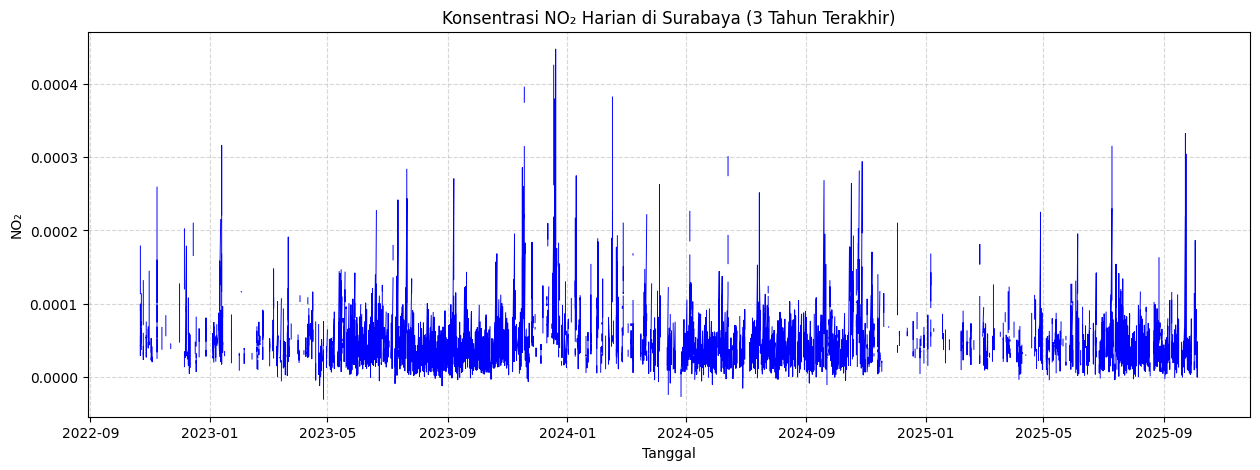

In [110]:
df['t'] = pd.to_datetime(df['t'])

plt.figure(figsize=(15,5))
plt.plot(df['t'], df['NO2'], color='blue', linewidth=0.7)
plt.title("Konsentrasi NO₂ Harian di Surabaya (3 Tahun Terakhir)")
plt.xlabel("Tanggal")
plt.ylabel("NO₂")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### **3.3 Cek Missing Value**

In [111]:
print(df.info())
print(df['NO2'].isna().sum(), "missing dari", len(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26875 entries, 0 to 26874
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t       26875 non-null  datetime64[ns]
 1   x       26875 non-null  float64       
 2   y       26875 non-null  float64       
 3   crs     26875 non-null  object        
 4   NO2     14373 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.0+ MB
None
12502 missing dari 26875


Terdapat Missing value pada kolom NO2 sebanyak 12.502, 46% dari data keseluruhan.

### **3.4 Cek Distribusi data**

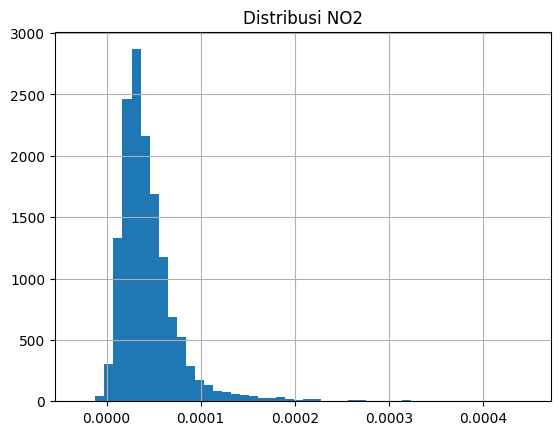

In [112]:
df['NO2'].dropna().hist(bins=50)
plt.title("Distribusi NO2")
plt.show()

## **4. Preprocessing data**

### **4.1 Deteksi dan Penanganan Outlier (IQR)**
Outlier atau pencilan adalah data yang nilainya sangat berbeda dari sebagian besar data lainnya. Di sini, kita akan menggunakan metode Interquartile Range (IQR) untuk mendeteksi dan menghapusnya. Data yang dianggap outlier akan diganti menjadi NaN (missing value) untuk kemudian ditangani bersama dengan missing value lainnya menggunakan interpolasi.

In [113]:
Q1 = df['NO2'].quantile(0.25)
Q3 = df['NO2'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['NO2'] < lower_bound) | (df['NO2'] > upper_bound)]
print(f"Jumlah outlier yang terdeteksi: {len(outliers)}")

# Ganti outlier dengan NaN
df.loc[(df['NO2'] < lower_bound) | (df['NO2'] > upper_bound), 'NO2'] = np.nan

print(f"Jumlah missing value setelah menghapus outlier: {df['NO2'].isna().sum()}")

Jumlah outlier yang terdeteksi: 732
Jumlah missing value setelah menghapus outlier: 13234


### **4.2 Penanganan Missing values**

Menangani Missing value (termasuk yang berasal dari outlier) menggunakan interpolasi linear berdasarkan waktu.

In [114]:
# pastikan kolom t sudah datetime dan jadi index
df['t'] = pd.to_datetime(df['t'])
df = df.set_index('t')

# interpolasi linear berbasis waktu
df['NO2'] = df['NO2'].interpolate(method='time', limit_direction='both')

# reset index
df = df.reset_index()

print(f"Sisa missing value setelah interpolasi: {df['NO2'].isna().sum()}")

Sisa missing value setelah interpolasi: 0


## **5. Modelling**

### **5.1 Analisis Autokorelasi (Seleksi Fitur)**
Sebelum membuat fitur lag, kita akan menganalisis autokorelasi (ACF) dari data deret waktu. Plot ACF membantu kita melihat korelasi antara data pada satu waktu dengan data pada waktu-waktu sebelumnya (lag). Lag yang memiliki korelasi tinggi (batangnya keluar dari area biru/confidence interval) dianggap signifikan dan baik untuk dijadikan fitur.

<Figure size 1500x600 with 0 Axes>

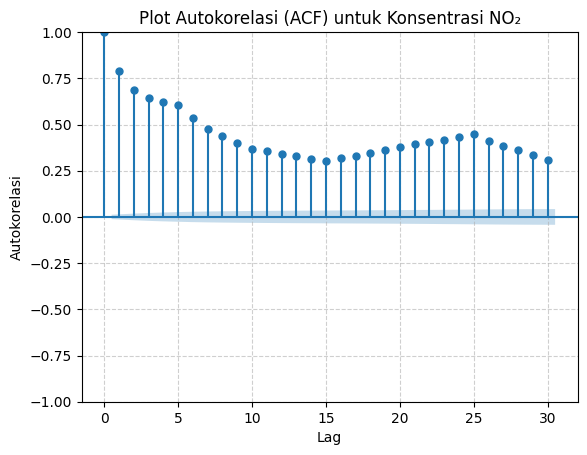

In [115]:
plt.figure(figsize=(15, 6))
plot_acf(df['NO2'], lags=30)
plt.xlabel("Lag")
plt.ylabel("Autokorelasi")
plt.title("Plot Autokorelasi (ACF) untuk Konsentrasi NO₂")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Dari plot ACF di atas, terlihat bahwa lag-lag awal (1 dan 3) memiliki korelasi yang sangat tinggi, yang menunjukkan adanya pola jangka pendek. Selain itu, terlihat puncak korelasi pada lag 3, 4, 5, 6, dan 7, yang mengindikasikan adanya pola musiman mingguan yang kuat. Berdasarkan analisis ini, kita akan menggunakan lag 1, 2, 3, 4, 5, 6, 7 dan juga kombinasi lag untuk menangkap pola sebagai fitur untuk model kita.

### **5.2 Buat data supervised (Lag feature)**

In [ ]:
df['NO2_lag1'] = df['NO2'].shift(1)
df['NO2_lag2'] = df['NO2'].shift(2)
df['NO2_lag3'] = df['NO2'].shift(3)
df['NO2_lag4'] = df['NO2'].shift(4)
df['NO2_lag5'] = df['NO2'].shift(5)
df['NO2_lag6'] = df['NO2'].shift(6)
df['NO2_lag7'] = df['NO2'].shift(7)

# Rolling mean & std
df['roll_mean_3'] = df['NO2'].rolling(window=3).mean()
df['roll_std_3']  = df['NO2'].rolling(window=3).std()

df['roll_mean_7'] = df['NO2'].rolling(window=7).mean()
df['roll_std_7']  = df['NO2'].rolling(window=7).std()

# Rolling min & max
df['roll_min_7'] = df['NO2'].rolling(window=7).min()
df['roll_max_7'] = df['NO2'].rolling(window=7).max()

#Exponential Moving Average (EMA)
df['ema_3'] = df['NO2'].ewm(span=3, adjust=False).mean()
df['ema_7'] = df['NO2'].ewm(span=7, adjust=False).mean()

#Differencing (untuk tangkap perubahan)
df['diff_1'] = df['NO2'].diff(1)   # perubahan 1 langkah
df['diff_7'] = df['NO2'].diff(7)   # perubahan mingguan

#pola harian/mingguan/musiman.
df['hour'] = pd.to_datetime(df['t']).dt.hour
df['dayofweek'] = pd.to_datetime(df['t']).dt.dayofweek
df['month'] = pd.to_datetime(df['t']).dt.month

# hapus baris yang ada NaN setelah membuat lag
df = df.dropna().reset_index(drop=True)

print(df.head())

           t           x         y  crs      NO2  NO2_lag1  NO2_lag2  \
0 2022-10-21  112.673585 -7.279512  b''  0.00009   0.00009   0.00009   
1 2022-10-21  112.673585 -7.314234  b''  0.00009   0.00009   0.00009   
2 2022-10-21  112.673585 -7.348957  b''  0.00009   0.00009   0.00009   
3 2022-10-21  112.728149 -7.210068  b''  0.00009   0.00009   0.00009   
4 2022-10-21  112.728149 -7.244790  b''  0.00009   0.00009   0.00009   

   NO2_lag3  NO2_lag4  NO2_lag5  ...  roll_std_7  roll_min_7  roll_max_7  \
0   0.00009   0.00009   0.00009  ...         0.0     0.00009     0.00009   
1   0.00009   0.00009   0.00009  ...         0.0     0.00009     0.00009   
2   0.00009   0.00009   0.00009  ...         0.0     0.00009     0.00009   
3   0.00009   0.00009   0.00009  ...         0.0     0.00009     0.00009   
4   0.00009   0.00009   0.00009  ...         0.0     0.00009     0.00009   

     ema_3    ema_7  diff_1  diff_7  hour  dayofweek  month  
0  0.00009  0.00009     0.0     0.0     0       

### **5.3 Normalisasi data**

menggunakan Min-Max scaler

In [117]:
features = [
    'NO2_lag1','NO2_lag2','NO2_lag3','NO2_lag4','NO2_lag5','NO2_lag6','NO2_lag7',
    'roll_mean_3','roll_std_3','roll_mean_7','roll_std_7',
    'roll_min_7','roll_max_7',
    'ema_3','ema_7',
    'diff_1','diff_7',
    'hour','dayofweek','month'
]

df_model = df.dropna().reset_index(drop=True)
X = df_model[features]
y = df_model['NO2']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### **5.4 Split data**
pisahkan train/test. 80% untuk training, 20% untuk testing.

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=False, test_size=0.2)

### **5.5 Training model**

Menggunakan model KNN Regression dengan tuning hyperparameter

In [119]:
knn = KNeighborsRegressor()

# Grid parameter yang mau dicoba
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearch dengan cross-validation
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,              # 5-fold cross validation
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Score (MSE):", grid.best_score_)

Best Params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Score (MSE): -1.1967441680819641e-11


In [120]:
model = KNeighborsRegressor(
    n_neighbors=7,
    weights='distance',
    metric='manhattan'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### **5.6 Evaluasi**

In [121]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.4f}")

MAE: 2.272455196731914e-06
RMSE: 3.296448519005184e-06
MAPE: 0.1131


hasil error dengan rata‑rata model sangat kecil sekali.
- MAE = rata‑rata kesalahan absolut.
- RMSE = rata‑rata kesalahan kuadrat, lebih sensitif terhadap error besar.
- MAPE = rata-rata persentase kesalahan absolut.

### **5.7 Plot Hasil Prediksi vs aktual**

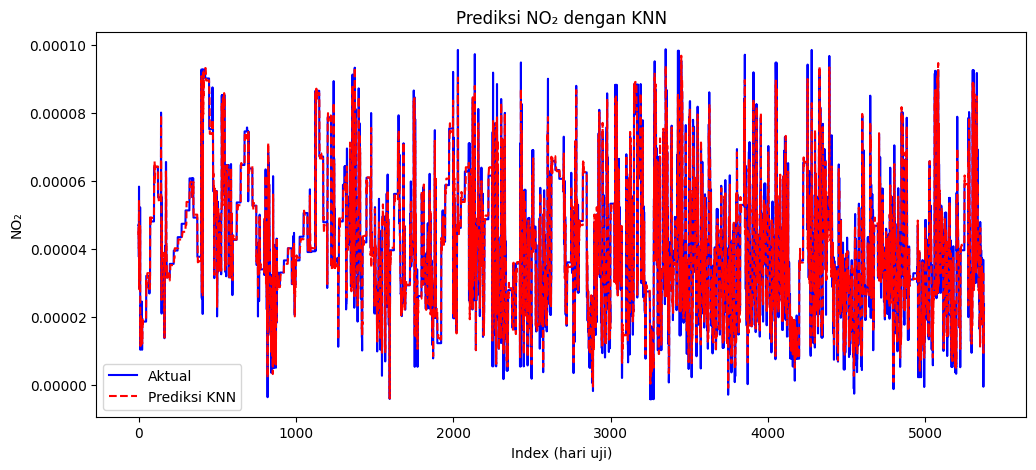

In [122]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Aktual", color="blue")
plt.plot(y_pred, label="Prediksi KNN", color="red", linestyle="--")
plt.title("Prediksi NO₂ dengan KNN")
plt.xlabel("Index (hari uji)")
plt.ylabel("NO₂")
plt.legend()
plt.show()